# TACO Trash Dataset

El conjunto de datos en cuestión tiene como objetivo la generación de un modelo que permita clasificar distintos tipos de residuos en diferentes categorías. Sin embargo, presenta varios desafíos inherentes al desbalance de datos, ya que algunas clases contienen muy pocos ejemplos en comparación con otras. Esto genera un sesgo que puede dificultar la correcta clasificación y generalización de los modelos entrenados, ya que el modelo tiende a aprender más sobre las clases con más ejemplos y podría desempeñarse mal en las clases con menos representatividad.

Además, la gran cantidad de categorías en el conjunto de datos genera complejidad, pues algunas clases presentan características visuales muy similares, lo que puede llevar a confusión durante el proceso de clasificación. Esto, combinado con el desbalance de datos, plantea la necesidad de redefinir el objetivo del modelo para mejorar su efectividad. En lugar de tratar de ajustar un modelo a un gran número de clases con distribuciones desiguales, se propone agrupar las categorías en categorías más generales y coherentes, basadas en sus similitudes visuales.

La redefinición de las clases podría permitir reducir la complejidad del problema, aumentar la eficiencia del modelo y mejorar su rendimiento.

In [2]:
%%script echo skipping

import os
from google.colab import drive

# Verificar si ya está montado
drive_mount_point = "/content/drive"
if not os.path.ismount(drive_mount_point):
    drive.mount(drive_mount_point)
    print("🔗 Google Drive montado.")
else:
    print("✅ Google Drive ya estaba montado.")


skipping


In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kneroma/tacotrashdataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tacotrashdataset


## 1. Importar librerías necesarias

In [5]:
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
import torchmetrics
from torchvision import transforms

## 2. Definir ruta del dataset local

In [6]:
DATASET_PATH = os.path.join(path, 'data')
ANNOTATION_FILE = os.path.join(DATASET_PATH, 'annotations.json')
print(ANNOTATION_FILE)
assert os.path.exists(ANNOTATION_FILE), 'No se encontró annotations.json en la ruta indicada'

/kaggle/input/tacotrashdataset/data/annotations.json


## 3. Cargar anotaciones desde archivo local

In [7]:
with open(ANNOTATION_FILE, 'r') as f:
    annotations = json.load(f)

print(annotations.keys())

dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


## 4. Estadísticas básicas del dataset

In [8]:
print('Cantidad de imágenes:', len(annotations['images']))
print('Cantidad de anotaciones:', len(annotations['annotations']))
print('Cantidad de categorías:', len(annotations['categories']))

Cantidad de imágenes: 1500
Cantidad de anotaciones: 4784
Cantidad de categorías: 60


## 5. Diccionarios de categorías y anotaciones

In [9]:
category_map = {cat['id']: cat['name'] for cat in annotations['categories']}
annotation_df = pd.DataFrame(annotations['annotations'])
annotation_df['category_name'] = annotation_df['category_id'].map(category_map)
annotation_df.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,category_name
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0,Other carton
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap


## 6. Distribución de residuos por clase

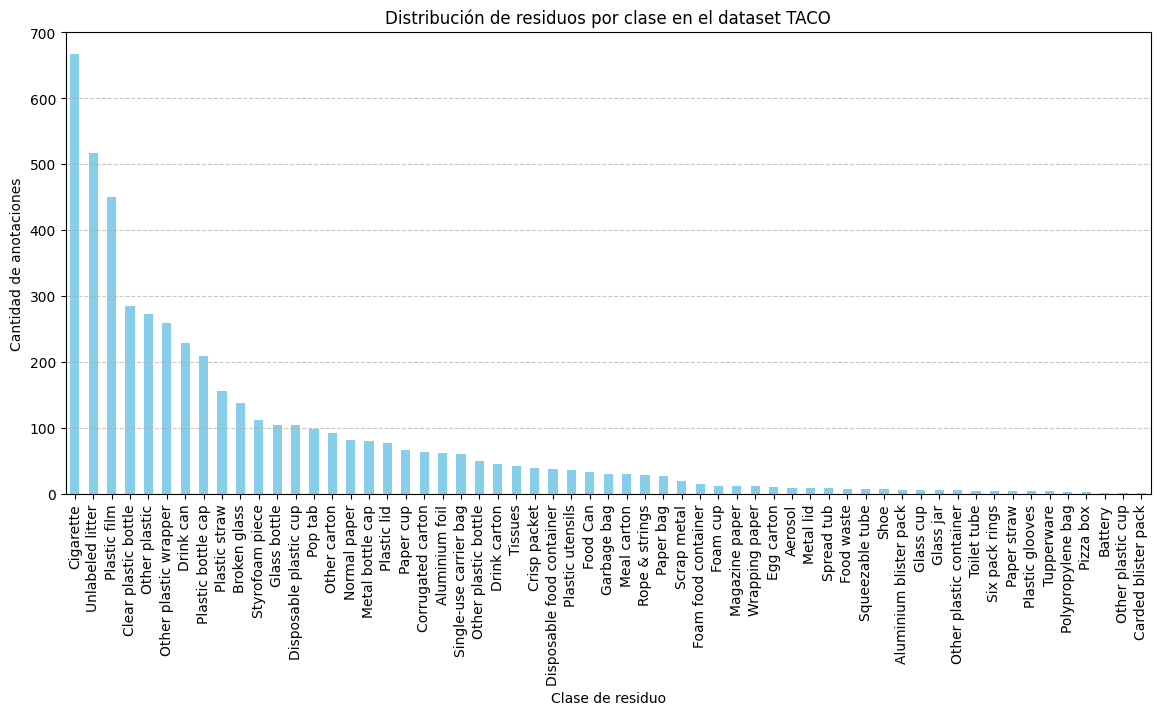

In [10]:
plt.figure(figsize=(14, 6))
annotation_df['category_name'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de residuos por clase en el dataset TACO')
plt.xlabel('Clase de residuo')
plt.ylabel('Cantidad de anotaciones')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 7. Desbalance del dataset

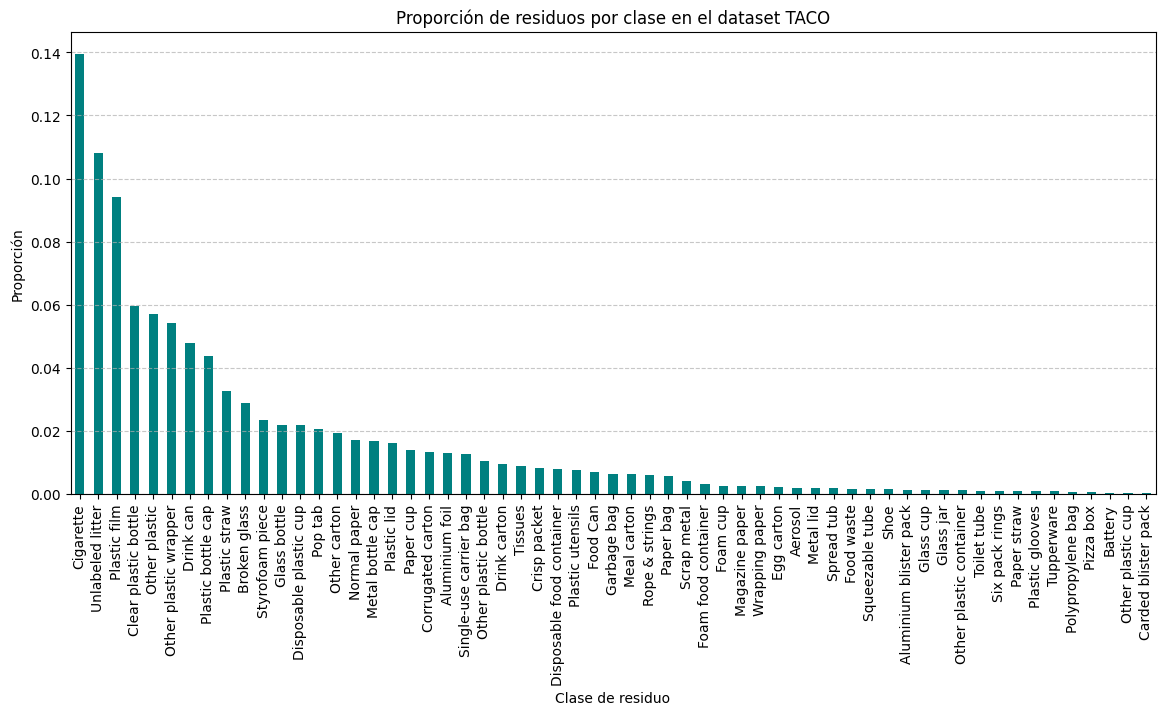

In [11]:
# Contar el número de anotaciones por clase
class_counts = annotation_df['category_name'].value_counts()

# Normalizar para obtener proporciones
class_proportions = class_counts / class_counts.sum()

# Graficar la distribución
plt.figure(figsize=(14, 6))
class_proportions.plot(kind='bar', color='teal')
plt.title('Proporción de residuos por clase en el dataset TACO')
plt.xlabel('Clase de residuo')
plt.ylabel('Proporción')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [12]:
print(class_proportions)

category_name
Cigarette                    0.139423
Unlabeled litter             0.108069
Plastic film                 0.094273
Clear plastic bottle         0.059574
Other plastic                0.057065
Other plastic wrapper        0.054348
Drink can                    0.047868
Plastic bottle cap           0.043687
Plastic straw                0.032818
Broken glass                 0.028846
Styrofoam piece              0.023411
Glass bottle                 0.021739
Disposable plastic cup       0.021739
Pop tab                      0.020694
Other carton                 0.019440
Normal paper                 0.017140
Metal bottle cap             0.016722
Plastic lid                  0.016095
Paper cup                    0.014005
Corrugated carton            0.013378
Aluminium foil               0.012960
Single-use carrier bag       0.012751
Other plastic bottle         0.010452
Drink carton                 0.009406
Tissues                      0.008779
Crisp packet                 0.00815

Hay muchas clases que se corresponden con menos del 1% de las imágenes del dataset.

In [13]:
minority_classes = [cls for cls, proportion in class_proportions.items() if proportion < 0.01]
minority_classes

['Drink carton',
 'Tissues',
 'Crisp packet',
 'Disposable food container',
 'Plastic utensils',
 'Food Can',
 'Garbage bag',
 'Meal carton',
 'Rope & strings',
 'Paper bag',
 'Scrap metal',
 'Foam food container',
 'Foam cup',
 'Magazine paper',
 'Wrapping paper',
 'Egg carton',
 'Aerosol',
 'Metal lid',
 'Spread tub',
 'Food waste',
 'Squeezable tube',
 'Shoe',
 'Aluminium blister pack',
 'Glass cup',
 'Glass jar',
 'Other plastic container',
 'Toilet tube',
 'Six pack rings',
 'Paper straw',
 'Plastic glooves',
 'Tupperware',
 'Polypropylene bag',
 'Pizza box',
 'Battery',
 'Other plastic cup',
 'Carded blister pack']

Se puede considerar agrupar algunas de estas clases.

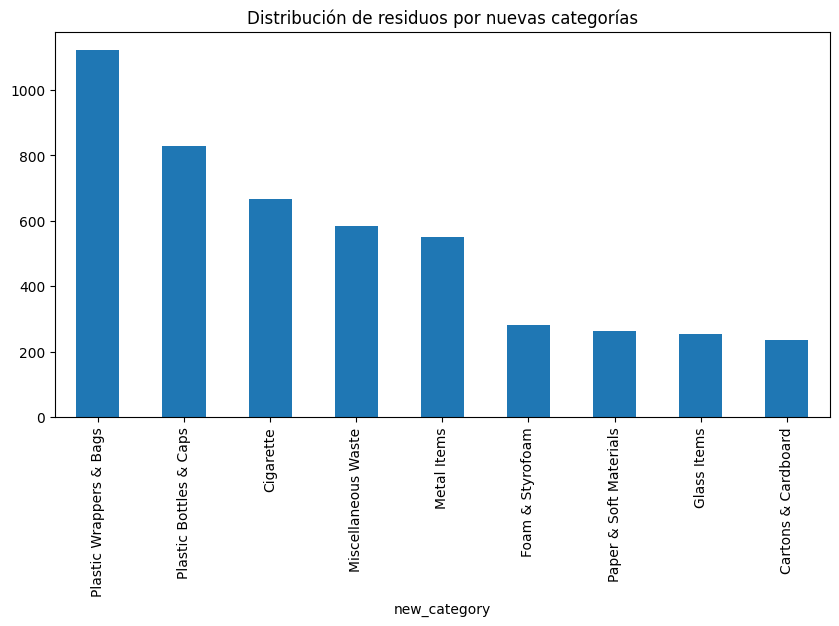

In [15]:
# Definir la agrupación de clases por material
custom_mapping = {
    "Cigarette": ["Cigarette"],
    "Glass Items": ["Broken glass", "Glass bottle", "Glass cup", "Glass jar"],
    "Metal Items": ["Drink can", "Pop tab", "Metal bottle cap", "Aluminium foil", "Scrap metal",
                    "Metal lid", "Aerosol", "Food Can", "Aluminium blister pack"],
    "Plastic Bottles & Caps": ["Plastic bottle cap", "Plastic bottle", "Other plastic bottle",
                               "Plastic utensils", "Tupperware", "Polypropylene bag", "Plastic straw",
                               "Plastic lid", "Plastic glooves", "Other plastic cup", "Clear plastic bottle"],
    "Plastic Wrappers & Bags": ["Plastic film", "Other plastic wrapper", "Single-use carrier bag",
                                "Other plastic container", "Garbage bag", "Plastic bag", "Other plastic bag",
                                "Crisp packet", "Other plastic"],
    "Cartons & Cardboard": ["Other carton", "Drink carton", "Meal carton", "Pizza box", "Corrugated carton"],
    "Paper & Soft Materials": ["Normal paper", "Paper cup", "Paper bag", "Magazine paper",
                               "Wrapping paper", "Egg carton", "Toilet tube", "Paper straw", "Tissues"],
    "Foam & Styrofoam": ["Styrofoam piece", "Disposable plastic cup", "Disposable food container",
                          "Foam food container", "Foam cup"],
    "Miscellaneous Waste": ["Unlabeled litter", "Rope & strings", "Food waste", "Shoe",
                            "Squeezable tube", "Battery", "Carded blister pack", "Spread tub", "Six pack rings"]
}



# Crear un diccionario inverso para mapeo rápido
class_to_material = {class_name: material for material, classes in custom_mapping.items() for class_name in classes}

# Copio para salvaguardar
new_annotation_df = annotation_df.copy()

# Suponiendo que 'df' es tu DataFrame con una columna 'category_name'
new_annotation_df['new_category'] = new_annotation_df['category_name'].map(class_to_material)

# Visualizar la distribución de las nuevas clases
new_annotation_df['new_category'].value_counts().plot(kind='bar', figsize=(10, 5), title='Distribución de residuos por nuevas categorías')

# Codificar nuevas categorías a partir de 'new_category'
category_mapping = {cat: idx for idx, cat in enumerate(new_annotation_df["new_category"].unique(), start=0)}
new_annotation_df["category_id"] = new_annotation_df["new_category"].map(category_mapping)

new_annotation_df.to_csv("new_annotations.csv", index=False)

In [16]:
missing_categories = new_annotation_df[new_annotation_df['new_category'].isna()]
print(missing_categories['category_name'].unique())

[]


In [17]:
new_annotation_df

,id,image_id,category_id,segmentation,area,bbox,iscrowd,category_name,new_category
0,1,0,0,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",4.039540e+05,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Glass Items
1,2,1,1,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1.071260e+06,"[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Cartons & Cardboard
2,3,1,1,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",9.958350e+04,"[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Cartons & Cardboard
3,4,2,2,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",7.383250e+04,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle,Plastic Bottles & Caps
4,5,2,2,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",9.150000e+02,"[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap,Plastic Bottles & Caps
...,...,...,...,...,...,...,...,...,...
4779,4779,1498,1,"[[386, 1557, 635, 1567, 986, 1556, 1178, 1550,...",5.032469e+05,"[228.7143, 1550.0476, 1007.9998999999999, 578....",0,Drink carton,Cartons & Cardboard
4780,4780,1498,2,"[[1057, 1824, 1041, 1793, 1042, 1758, 1062, 17...",1.449450e+04,"[1041.3334, 1721.7142, 141.0, 138.0]",0,Plastic bottle cap,Plastic Bottles & Caps
4781,4781,1499,4,"[[1368, 1775, 1099, 1331, 862, 1494, 1099, 1944]]",1.549541e+05,"[862.0274, 1331.25, 505.97260000000006, 612.5]",0,Other plastic wrapper,Plastic Wrappers & Bags
4782,4782,1499,1,"[[1096, 1996, 1121, 2069, 1134, 2127, 1177, 22...",2.867500e+04,"[966.0, 1996.0, 211.0, 336.0]",0,Other carton,Cartons & Cardboard


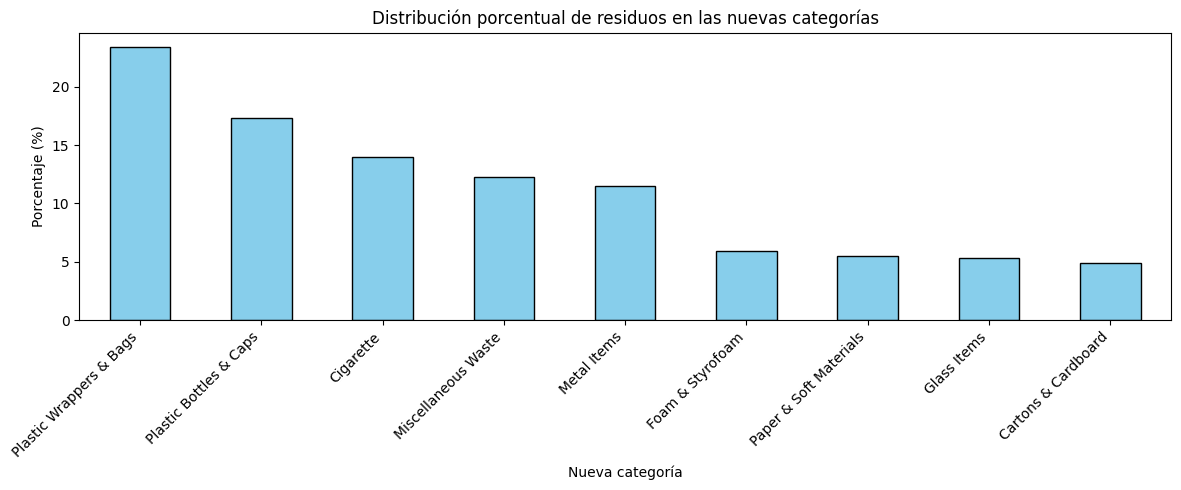

In [18]:
# Calcular proporciones de las nuevas categorías
new_class_counts = new_annotation_df["new_category"].value_counts(normalize=True) * 100

# Graficar distribución
plt.figure(figsize=(12, 5))
new_class_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribución porcentual de residuos en las nuevas categorías")
plt.xlabel("Nueva categoría")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [19]:
new_class_counts

,proportion
new_category,
Plastic Wrappers & Bags,23.432274
Plastic Bottles & Caps,17.307692
Cigarette,13.942308
Miscellaneous Waste,12.228261
Metal Items,11.496656
Foam & Styrofoam,5.894649
Paper & Soft Materials,5.476589
Glass Items,5.309365
Cartons & Cardboard,4.912207


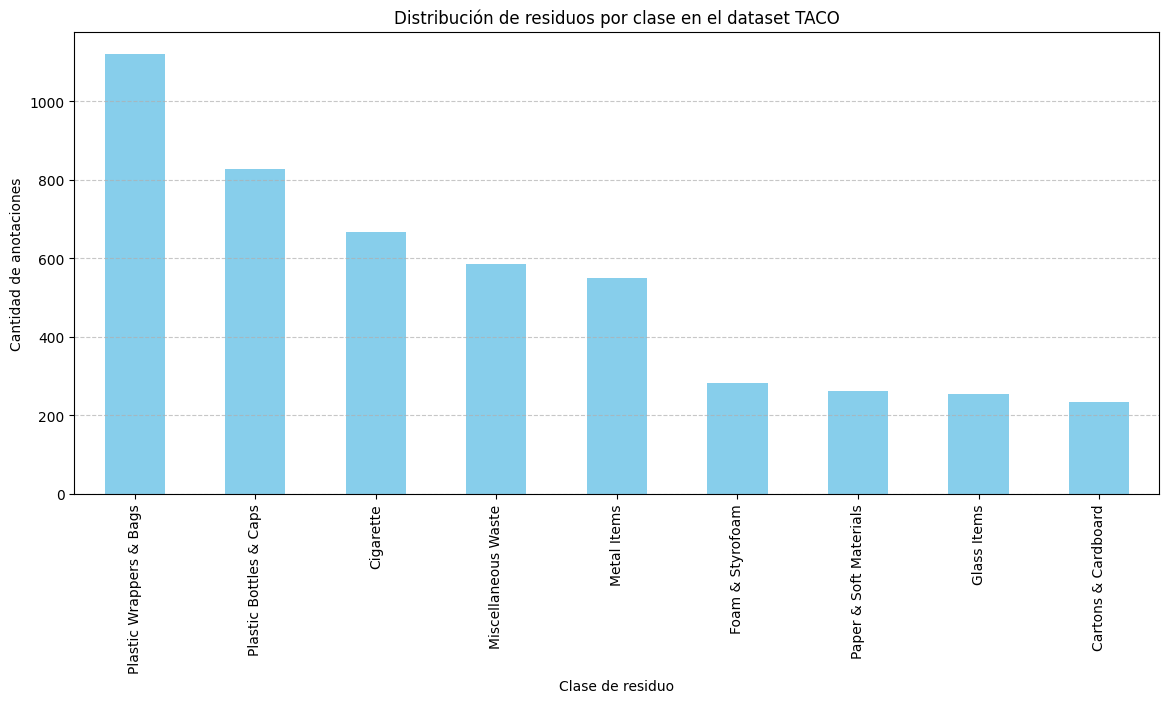

In [20]:
plt.figure(figsize=(14, 6))
new_annotation_df['new_category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de residuos por clase en el dataset TACO')
plt.xlabel('Clase de residuo')
plt.ylabel('Cantidad de anotaciones')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 8. Anotaciones por imagen

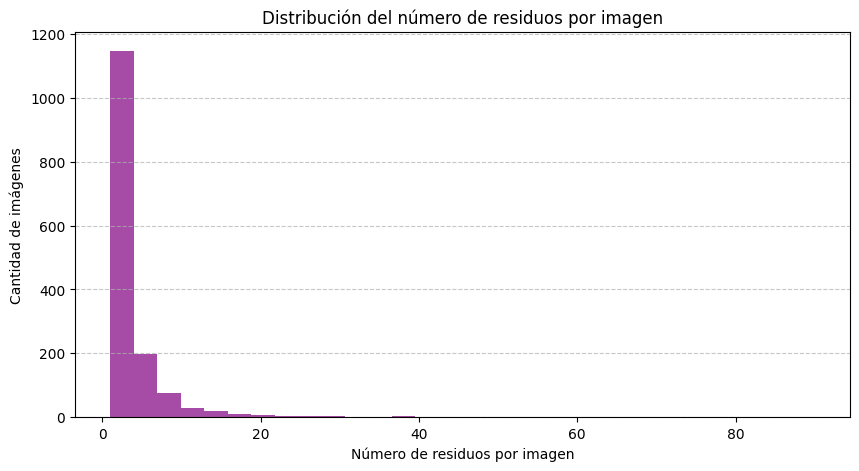

In [21]:
# Contar anotaciones por imagen
annotations_per_image = annotation_df['image_id'].value_counts()

# Graficar histograma
plt.figure(figsize=(10, 5))
plt.hist(annotations_per_image, bins=30, color='purple', alpha=0.7)
plt.title('Distribución del número de residuos por imagen')
plt.xlabel('Número de residuos por imagen')
plt.ylabel('Cantidad de imágenes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Hay muy pocas imágenes que contengan muchas anotaciones, y hay muchas imagenes que contengan pocas anotaciones.



## 9. Aparición de clases en una misma imagen

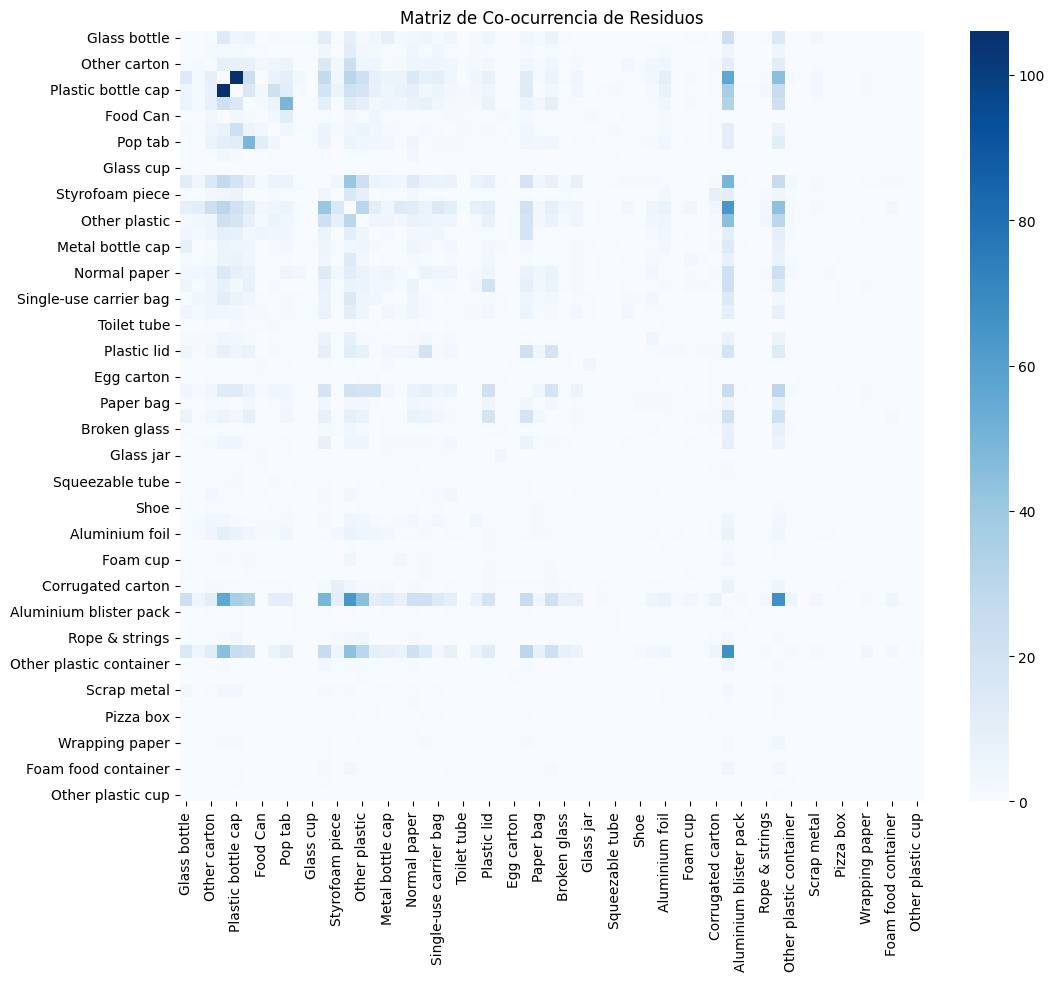

In [22]:
from itertools import combinations
import numpy as np
import seaborn as sns

# Crear un diccionario que mapea cada imagen a las clases presentes en ella
image_classes = annotation_df.groupby('image_id')['category_name'].unique()

# Crear una matriz vacía de co-ocurrencia
categories = annotation_df['category_name'].unique()
co_occurrence_matrix = pd.DataFrame(0, index=categories, columns=categories)

# Llenar la matriz contando co-ocurrencias
for classes in image_classes:
    for c1, c2 in combinations(classes, 2):
        co_occurrence_matrix.loc[c1, c2] += 1
        co_occurrence_matrix.loc[c2, c1] += 1

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, cmap="Blues", annot=False)
plt.title("Matriz de Co-ocurrencia de Residuos")
plt.show()

La co-ocurrencia más pronunciada es entre "Other carton" y "Plastic bottle cap".

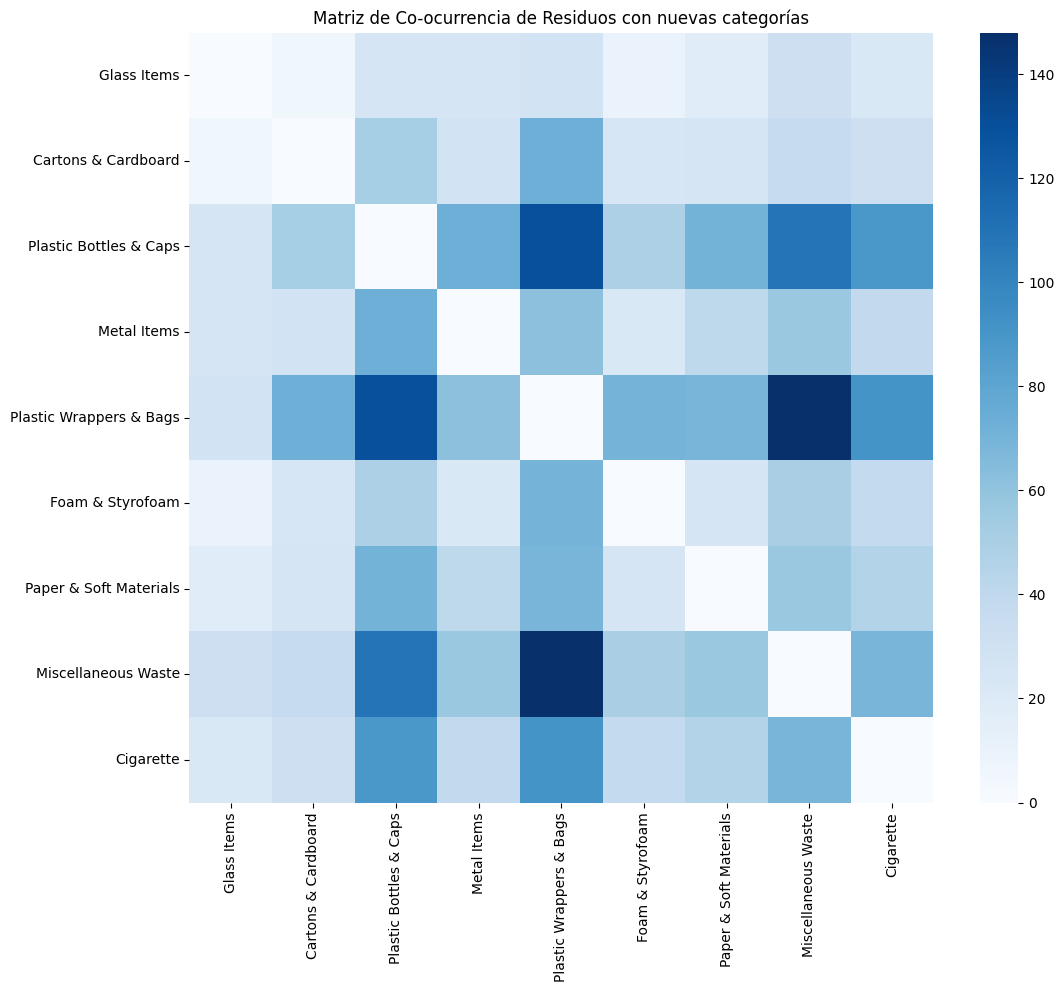

In [23]:
# Crear un diccionario que mapea cada imagen a las clases presentes en ella
image_classes = new_annotation_df.groupby('image_id')['new_category'].unique()

# Crear una matriz vacía de co-ocurrencia
categories = new_annotation_df['new_category'].unique()
co_occurrence_matrix = pd.DataFrame(0, index=categories, columns=categories)

# Llenar la matriz contando co-ocurrencias
for classes in image_classes:
    for c1, c2 in combinations(classes, 2):
        co_occurrence_matrix.loc[c1, c2] += 1
        co_occurrence_matrix.loc[c2, c1] += 1

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, cmap="Blues", annot=False)
plt.title("Matriz de Co-ocurrencia de Residuos con nuevas categorías")
plt.show()

## 10. Visualización de ejemplos de clases originales

In [24]:
image_map = {image['id']: image for image in annotations['images']}

In [25]:
for class_id, class_name in category_map.items():
    # Filtrar anotaciones de esta clase
    class_annotations = annotation_df[annotation_df['category_id'] == class_id]

    if class_annotations.empty:
        print(f"No hay ejemplos para la clase: {class_name}")
        continue

    # Tomar la primera anotación de esta clase
    example = class_annotations.iloc[0]
    image_info = image_map[example['image_id']]
    image_path = os.path.join(DATASET_PATH, image_info['file_name'])

    # Cargar la imagen
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(img)

    # Dibujar todos los objetos de esa clase en esta imagen
    for _, ann in class_annotations[class_annotations['image_id'] == image_info['id']].iterrows():
        bbox = ann['bbox']
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1], class_name, color='white', fontsize=8,
                bbox=dict(facecolor='red', alpha=0.5))

    plt.title(f"Ejemplo de clase: {class_name}")
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## 11. Limpieza en el dataset

In [26]:
low_annotation_images = annotations_per_image[annotations_per_image < 1].index.tolist()
low_annotation_images

[]

No hay imágenes sin anotaciones.